# Fundamentals-unknown-replication-notebook

In [1]:
%matplotlib inline
import math
import numpy as np
import numpy.random as nrand
import matplotlib.pyplot as plt
import pandas as pd
import itertools
import scipy.stats as stats
from pandas_datareader import data
from stockmarket.stylizedfacts import *
from math import isclose
import matplotlib.cm as cm
from pandas.tools.plotting import autocorrelation_plot
from stockmarket.database import create_CDA_tables, record_state_variables
import powerlaw
from tqdm import *
from stockmarket import baselinemodel
import sqlite3
import ast
import json
import re

In [30]:
from matplotlib import style
style.use('seaborn-white')

In [194]:
#style.available

## Initialise parameters

In [2]:
# also initialise these if you just do the data analysis
SIMTIME = 200
NRUNS = 50

In [3]:
calibratedParams = {"price_to_earnings_base": 11, 
                    "longMA_heterogeneity": 1.441986880130183, 
                    "price_to_earnings_gap": 11, 
                    "agents_hold_thresholds": 0.009787868843112115, 
                    "agent_ma_long": 65, 
                    "shortMA_heterogeneity": 1.204473734660668, 
                    "price_to_earnings_heterogeneity": 1.2809853358963714, 
                    "profit_announcement_working_days": 13, 
                    "agent_order_price_variability": 2, 
                    "agent_volume_risk_aversion": 0.15710589508611844, 
                    "share_chartists": 0.6360219452317543, 
                    "agent_order_variability": 0.41645196996101297, 
                    "agent_propensity_to_switch": 1.879037190114386, 
                    "agent_ma_short": 50, 
                    "shortMA_memory_divider": 3.539424126160756, 
                    "share_mean_reversion": 0.3380862907737759, 
                    "order_expiration_time": 6791,
                    'init_money': 26000,
                    'init_profit': 1000,
                    'init_discount_rate': 0.17}

In [4]:
initial_total_money = calibratedParams['init_money']
init_profit = calibratedParams['init_profit']
init_discount_rate = calibratedParams['init_discount_rate']
price_to_earnings_base = calibratedParams['price_to_earnings_base']
longMA_heterogeneity = calibratedParams['longMA_heterogeneity']
price_to_earnings_gap = calibratedParams['price_to_earnings_gap']
agents_hold_thresholds = calibratedParams['agents_hold_thresholds']
agent_ma_long = calibratedParams['agent_ma_long']
shortMA_heterogeneity = calibratedParams['shortMA_heterogeneity']
price_to_earnings_heterogeneity = calibratedParams['price_to_earnings_heterogeneity']
profit_announcement_working_days = calibratedParams['profit_announcement_working_days']
agent_order_price_variability = calibratedParams['agent_order_price_variability']
agent_volume_risk_aversion = calibratedParams['agent_volume_risk_aversion']
share_chartists = calibratedParams['share_chartists']
agent_order_variability = calibratedParams['agent_order_variability']
agent_propensity_to_switch = calibratedParams['agent_propensity_to_switch']
agent_ma_short = calibratedParams['agent_ma_short']
shortMA_memory_divider = calibratedParams['shortMA_memory_divider']
share_mean_reversion = calibratedParams['share_mean_reversion']
order_expiration_time = calibratedParams['order_expiration_time']

In [5]:
n_agents = 1000
n_firms = 1
firm_profit_mu = 0.058
firm_profit_delta = 0.00396825396
firm_profit_sigma = 0.125

In [6]:
PE_low_low = price_to_earnings_base
PE_low_high = int(price_to_earnings_heterogeneity*price_to_earnings_base)
PE_high_low = PE_low_high + price_to_earnings_gap
PE_high_high = int(price_to_earnings_heterogeneity*PE_high_low)

## Create sqlite database

In [7]:
conn = sqlite3.connect('baseline.sqlite')
cur = conn.cursor()

## Simulate the model and store the results in the database

In [8]:
for seed in tqdm(range(NRUNS)): # optional, remove tqdm(), it is used for the progress bar
    create_CDA_tables(cur, seed)
    agents, firms, stocks, order_books = baselinemodel.stockMarketSimulation(seed=seed,
                                                                             simulation_time=SIMTIME,
                                                                         init_backward_simulated_time=int(agent_ma_long*longMA_heterogeneity),
                                                                         number_of_agents=n_agents,
                                                                         share_chartists=share_chartists,
                                                                         share_mean_reversion=share_mean_reversion,
                                                                         amount_of_firms=n_firms,
                                                                         initial_total_money=(initial_total_money,int(initial_total_money*1.1)),
                                                                         initial_profit=(init_profit, init_profit),
                                                                         discount_rate=init_discount_rate,
                                                                         init_price_to_earnings_window=((PE_low_low,
                                                                                                         PE_low_high),
                                                                                                        (PE_high_low,
                                                                                                         PE_high_high)),
                                                                         order_expiration_time=order_expiration_time,
                                                                         agent_order_price_variability=(agent_order_price_variability,agent_order_price_variability),
                                                                         agent_order_variability=agent_order_variability,
                                                                         agent_ma_short=(agent_ma_short, int(agent_ma_short*shortMA_heterogeneity)),
                                                                         agent_ma_long=(agent_ma_long, int(agent_ma_long*longMA_heterogeneity)),
                                                                         agents_hold_thresholds=(1-agents_hold_thresholds, 1+agents_hold_thresholds),
                                                                         agent_volume_risk_aversion=agent_volume_risk_aversion,
                                                                         agent_propensity_to_switch=agent_propensity_to_switch,
                                                                         firm_profit_mu=firm_profit_mu,
                                                                         firm_profit_delta=firm_profit_delta,
                                                                         firm_profit_sigma=firm_profit_sigma,
                                                                         profit_announcement_working_days=profit_announcement_working_days,
                                                                             mean_reversion_memory_divider=4,
                                                                         printProgress=False,
                                                                         )
    record_state_variables(cur, seed, agents, SIMTIME, firms, stocks, order_books)
    conn.commit()

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [48:12<00:00, 63.29s/it]


## Close the connection to the database

In [9]:
cur.close()

## S&P 500 data

In [10]:
start_date = '2010-01-01'
end_date = '2016-12-31'

spy = data.DataReader("SPY", 
                       start=start_date, 
                       end=end_date, 
                       data_source='google')['Close']

#spy.plot(title='AAPL Adj. Closing Price')
spy_returns = spy.pct_change()

spy_volume = data.DataReader("SPY", 
                       start=start_date, 
                       end=end_date, 
                       data_source='google')['Volume']

# Data analysis

* Price-to-earnings
* Closing prices
* Returns
* Volume

In [11]:
# connect to the database
conn = sqlite3.connect('baseline.sqlite')
cur = conn.cursor()

## Price to earnings

The stock keeps track of the price-to-earnings ratio. First, we retrieve it from the database. 

In [195]:
stockVariables = []
for seed in range(NRUNS):
    stockVariables.append(pd.read_sql_query(
    """
    SELECT Statevariables{0}.seed ,Statevariables{0}.period, Variabletypes{0}.variable_type, Objects{0}.object_name, Objects{0}.object_type ,Statevariables{0}.value 
    FROM Statevariables{0} JOIN Variabletypes{0} JOIN Objects{0} ON Statevariables{0}.variable_id = Variabletypes{0}.id and Statevariables{0}.owner_id = Objects{0}.id 
    WHERE Objects{0}.object_type = 'stock'
    """.format(seed), conn))

In [196]:
stockVariables = pd.concat(stockVariables)

In [197]:
stockVariables['variable_type'].unique()

array(['face_value', 'name', 'firm', 'price_history',
       'price_to_earnings_history', 'amount'], dtype=object)

In [198]:
len(stockVariables.query('variable_type == "price_to_earnings_history" and seed == 0'))

200

In [199]:
# for one seed loop over the period
pe_per_seed = []
for seed in range(NRUNS):
    pe = []
    for ptoe in stockVariables.query('seed == {} and variable_type == "price_to_earnings_history"'.format(seed))['value']:
        pe.append(float(ptoe))
    pe_per_seed.append(pe)

In [200]:
price_to_earnings = pe_per_seed[0]

# Returns and volume
The orderbook keeps track of the stock price and volume history.
* orderbook.transaction_prices_history
* orderbook.transaction_volumes_history

In [201]:
def calculate_returns(orderbook_transaction_price_history):
    """Return the returns"""
    closing_prices = []
    for day in orderbook_transaction_price_history:
        closing_prices.append(day[-1])
    returns = pd.Series(closing_prices).pct_change()
    return returns[1:]

In [202]:
orderbook_price_and_volumes = []
for seed in range(NRUNS):
    orderbook_price_and_volumes.append(pd.read_sql_query(
    """
    SELECT Statevariables{0}.seed ,Statevariables{0}.period, Variabletypes{0}.variable_type, Objects{0}.object_name, Objects{0}.object_type ,Statevariables{0}.value 
    FROM Statevariables{0} JOIN Variabletypes{0} JOIN Objects{0} ON Statevariables{0}.variable_id = Variabletypes{0}.id and Statevariables{0}.owner_id = Objects{0}.id 
    WHERE Objects{0}.object_type = 'order' AND Variabletypes{0}.variable_type = 'transaction_prices_history' OR Variabletypes{0}.variable_type = 'transaction_volumes_history'
    """.format(seed), conn))

In [203]:
orderbook_price_and_volumes = pd.concat(orderbook_price_and_volumes)

## Calculate closing prices

In [204]:
# for one seed loop over the period
prices_per_seed = []
for seed in range(NRUNS):
    prices_history = []
    for prices in orderbook_price_and_volumes.query('seed == {} and variable_type == "transaction_prices_history"'.format(seed))['value']:
        prices_history.append(ast.literal_eval(prices))
    prices_per_seed.append(prices_history)

In [205]:
# record volumes per seed
closingprices = []
for prices in prices_per_seed:
    closingprices_seed = []
    for day in prices:
        closingprices_seed.append(day[-1])
    closingprices.append(closingprices_seed)

## Calculate returns

In [206]:
returns = []
for seed_close_prices in closingprices:
    returns.append(pd.Series(np.array(seed_close_prices)).pct_change())


#returns = pd.Series(np.array(closingprices)).pct_change()

## Calculate volume 

In [207]:
# for one seed loop over the period
volumes_per_seed = []
for seed in range(NRUNS):
    volume_history = []
    for vol in orderbook_price_and_volumes.query('seed == {} and variable_type == "transaction_volumes_history"'.format(seed))['value']:
        volume_history.append(ast.literal_eval(vol))
    volumes_per_seed.append(volume_history)

In [208]:
# record volumes per seed
totalvolume = []
for seed_vol in volumes_per_seed:
    total_seed_volume = []
    for day in seed_vol:
        total_seed_volume.append(sum(day))
    totalvolume.append(total_seed_volume)

# Model dynamics 

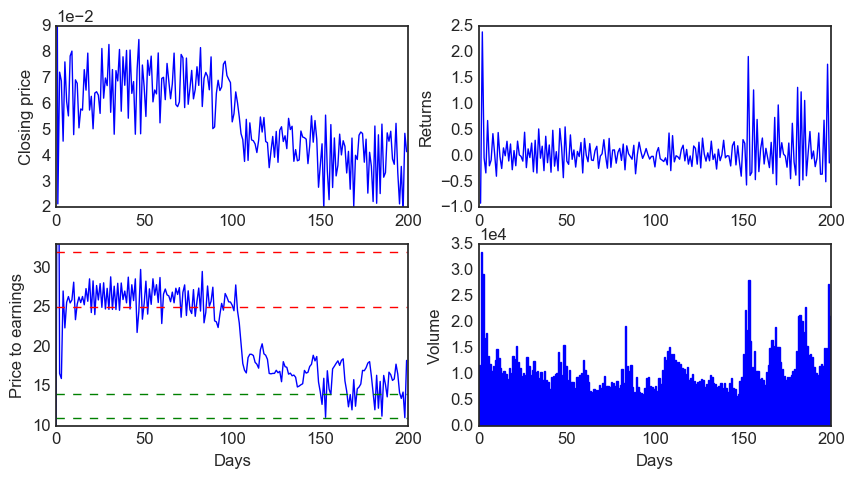

In [209]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10,5))

ax1.plot(range(len(closingprices[0])), closingprices[0])
ax1.set_ylim(0.02, 0.09)
ax1.set_ylabel('Closing price', fontsize='12')

ax2.plot(range(len(returns[0])), returns[0])
ax2.set_ylabel('Returns', fontsize='12')

ax3.plot(range(len(price_to_earnings)), price_to_earnings)
ax3.plot(range(len(price_to_earnings)), [PE_low_low for x in range(len(price_to_earnings))], 'g--')
ax3.plot(range(len(price_to_earnings)), [PE_low_high for x in range(len(price_to_earnings))], 'g--')
ax3.plot(range(len(price_to_earnings)), [PE_high_low for x in range(len(price_to_earnings))], 'r--')
ax3.plot(range(len(price_to_earnings)), [PE_high_high for x in range(len(price_to_earnings))], 'r--')
ax3.set_ylim(10, 33)
ax3.set_ylabel('Price to earnings', fontsize='12')
ax3.set_xlabel('Days', fontsize='12')

ax4.bar(range(len(totalvolume[0])), totalvolume[0], edgecolor='b')
ax4.set_ylabel('Volume', fontsize='12')
ax4.set_xlabel('Days', fontsize='12')

for ax in [ax1, ax2, ax3, ax4]:
    ax.ticklabel_format(axis='y', style='sci', scilimits=(-2,2))
    
fig.savefig('model_dynamics.png')

# Switching behaviour

In [92]:
function_history = []
for seed in range(NRUNS):
    function_history.append(pd.read_sql_query(
    """
    SELECT Statevariables{0}.seed ,Statevariables{0}.period, Variabletypes{0}.variable_type, Objects{0}.object_name, Objects{0}.object_type ,Statevariables{0}.value 
    FROM Statevariables{0} JOIN Variabletypes{0} JOIN Objects{0} ON Statevariables{0}.variable_id = Variabletypes{0}.id and Statevariables{0}.owner_id = Objects{0}.id 
    WHERE Variabletypes{0}.variable_type = 'function_history'
    """.format(seed), conn))

In [93]:
function_history= pd.concat(function_history)

In [94]:
def percentageMomentum(period, df):
    df = df.query('period == {}'.format(period))
    momentum = 0
    queryString = 'momentum'
    functions = df['value']
    for func in functions:
        if queryString in func:
            momentum += 1
    return momentum / (len(functions))

In [95]:
# for one seed loop over the period
functions_per_seed = []
for seed in range(NRUNS):
    seed_functions = function_history.query('seed == {}'.format(seed))
    functions_per_seed.append(seed_functions)

In [97]:
percMom = []
for period in range(SIMTIME):
    percMom.append(percentageMomentum(period, functions_per_seed[0]))

In [98]:
share_noise_traders = np.array([1 - calibratedParams['share_chartists'] for x in range(SIMTIME)])
share_momentum = np.array(percMom)
percMeanRev = np.ones(SIMTIME) - share_noise_traders - share_momentum

In [99]:
colors= plt.cm.Set1(np.linspace(0, 1, 12))

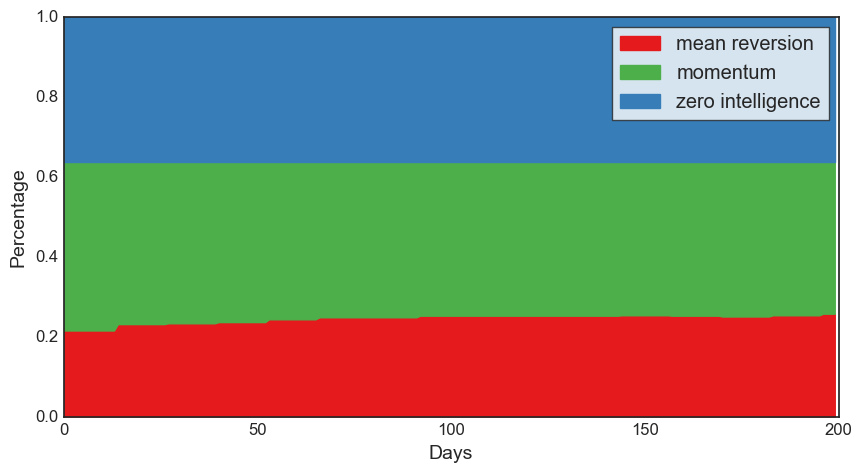

In [157]:
fig, ax1 = plt.subplots(1, 1, figsize=(10,5))

ax1.fill_between(range(len(percMom)), percMeanRev, 0,label='mean reversion', alpha=1, color=colors[0])
ax1.fill_between(range(len(percMom)), share_momentum + percMeanRev, percMeanRev, label='momentum', color=colors[3], alpha=1)
ax1.fill_between(range(len(percMom)), 
                 share_noise_traders+share_momentum + percMeanRev, share_momentum + percMeanRev,label='zero intelligence', color=colors[2])

ax1.set_ylabel('Percentage', fontsize='14')
ax1.set_xlabel('Days', fontsize='14')
ax1.legend(frameon=True, loc='best', framealpha=0.8)
fig.savefig('trader_population.png')

# Stylized facts

In [87]:
from stockmarket.stylizedfacts import *

### 1 No autocorrelation in returns 

In [133]:
autocorr_returns = {}
for idx, seed_returns in enumerate(returns):
    autocorr_returns['seed_{}'.format(idx)] = [seed_returns[1:].autocorr(lag=lag) for lag in range(25)]

In [122]:
#autocorr_returns = [returns[0][1:].autocorr(lag=lag) for lag in range(25)]
autocorr_spy_returns = [spy_returns[200:].autocorr(lag=lag) for lag in range(25)]

In [135]:
autocorr_returns = pd.DataFrame(autocorr_returns)

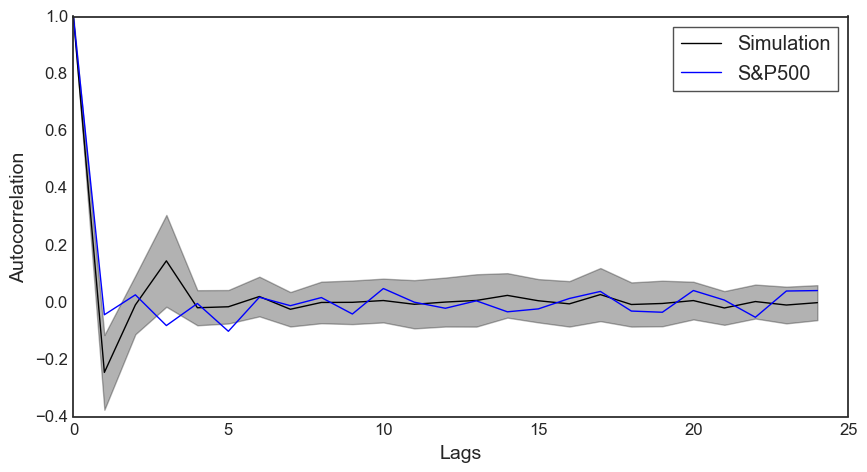

In [156]:
fig, ax1 = plt.subplots(1, 1, figsize=(10,5))

#ax1.plot(range(len(autocorr_returns[0])), autocorr_returns[0], label='Model')

ax1.plot(autocorr_returns.index, autocorr_returns.mean(axis=1), 'k-', label='Simulation')
ax1.fill_between(autocorr_returns.index, 
                 autocorr_returns.mean(axis=1)+autocorr_returns.std(axis=1), 
                 autocorr_returns.mean(axis=1)-autocorr_returns.std(axis=1), 
                 alpha=0.3, facecolor='black')


ax1.plot(range(len(autocorr_spy_returns)), autocorr_spy_returns, label='S&P500')

ax1.legend(frameon=True, loc='best', framealpha=0.8)
ax1.set_ylabel('Autocorrelation', fontsize='14')
ax1.set_xlabel('Lags', fontsize='14')
fig.savefig('auto_correlation.png')

In [184]:
np.mean(autocorr_returns.mean(axis=1)[1:])

-0.005503452342737428

## 2 Fat tails

In [176]:
ftails = []
for ret in returns:
    ftails.append(fat_tails_kurtosis(ret)[1])

In [180]:
np.mean(ftails)

94.37143689093233

In [149]:
print('Fat tail in model (kurtosis): ',fat_tails_kurtosis(returns[0]))
print('Fat tail in SP500 (kurtosis): ',fat_tails_kurtosis(spy_returns[200:]))

Fat tail in model (kurtosis):  (True, 8.5936433442835547)
Fat tail in SP500 (kurtosis):  (True, 4.1262033360051857)


## 3 Clustered volatility

In [140]:
absolute_returns = [ret.abs() for ret in returns]
autocorr_returns_abs = {}
for idx, seed_returns in enumerate(absolute_returns):
    autocorr_returns_abs['seed_{}'.format(idx)] = [seed_returns[1:].autocorr(lag=lag) for lag in range(25)]

In [144]:
autocorr_returns_abs = pd.DataFrame(autocorr_returns_abs)

In [141]:
#autocorr_abs_returns = [absolute_returns.autocorr(lag=lag) for lag in range(25)]
absolute_spy_returns = spy_returns.abs()
autocorr_spy_abs_returns = [absolute_spy_returns.autocorr(lag=lag) for lag in range(25)]

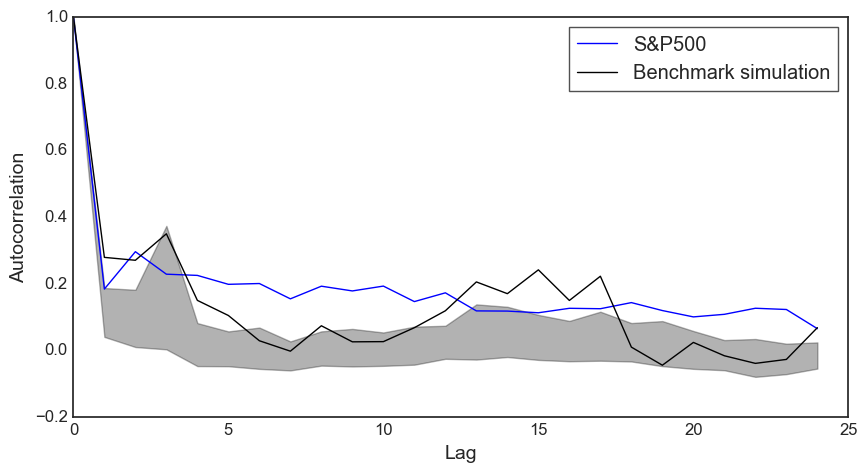

In [152]:
fig, ax1 = plt.subplots(1, 1, figsize=(10,5))

#ax1.plot(range(len(autocorr_abs_returns)), autocorr_abs_returns, label='Model')
ax1.plot(range(len(autocorr_spy_abs_returns)), autocorr_spy_abs_returns, label='S&P500')

ax1.plot(autocorr_returns_abs.index, autocorr_returns_abs['seed_0'], 'k-', label='Benchmark simulation')
ax1.fill_between(autocorr_returns_abs.index, 
                 autocorr_returns_abs.mean(axis=1)+autocorr_returns_abs.std(axis=1), 
                 autocorr_returns_abs.mean(axis=1)-autocorr_returns_abs.std(axis=1), 
                 alpha=0.3, facecolor='black')


ax1.legend(frameon=True, loc='best', framealpha=0.8)
ax1.set_ylabel('Autocorrelation', fontsize='14')
ax1.set_xlabel('Lag', fontsize='14')
fig.savefig('auto_correlation_abs.png')

In [170]:
def cclustered_volatility(returns, lags):
    absolute_returns = returns.abs()
    autocorr_abs_returns = [absolute_returns.autocorr(lag=lag) for lag in range(lags)]
    average_autocorrelation = np.mean(autocorr_abs_returns[1:])
    #print(average_autocorrelation)
    return average_autocorrelation

In [171]:
cvol = []
for ret in returns:
    cvol.append(cclustered_volatility(ret, 25))

In [174]:
print('average volatility clustering',np.mean(cvol))

average volatility clustering 0.0255890132009


In [150]:
print('Clustered volatility in model: ',clustered_volatility(returns[0], 25)) 
print('Clustered volatility in SP500: ',clustered_volatility(spy_returns[200:], 25))

Clustered volatility in model:  (True, 0.10075088133411832)
Clustered volatility in SP500:  (True, 0.16021987826537545)


## 4 Long memory

In [160]:
hursts = []
for ret in returns:
    hursts.append(long_memory(ret, hurst, 2, 20)[1])

In [164]:
print('Model long memory (hurst)', np.mean(hursts))
print('SP500 long memory (hurst)', long_memory(spy_returns[200:], hurst, 2, 20))

Model long memory (hurst) 0.011827285251
SP500 long memory (hurst) (True, -0.002499728651410653)


## 5 Correlation between volume and return volatility

In [185]:
window = 10

In [192]:
totVol = totalvolume[0]
# volume
voll = pd.Series(totVol)
roller_sim_vol = voll.rolling(window)
volatility_sim_vol = roller_sim_vol.std(ddof=0)
roller_spy_vol = spy_volume[:200].rolling(window)
volatility_spy_vol = roller_spy_vol.std(ddof=0)
# returns
spy_roller_returns = spy_returns[:200].rolling(window)
spy_returns_volatility = spy_roller_returns.std(ddof=0)
sim_returns = returns[0]
roller_returns = sim_returns.rolling(window)
returns_volatility = roller_returns.std(ddof=0)

In [188]:
correlations = []
for vol, ret in zip(totalvolume, returns):
    vol = pd.Series(vol)
    sim_returns = ret
    roller_returns = sim_returns.rolling(window)
    returns_volatility = roller_returns.std(ddof=0)
    correlations.append(returns_volatility.corr(vol))

In [190]:
np.mean(correlations)

0.20679137456998464

In [193]:
print('Model cor vol volatility: ', returns_volatility.corr(voll))
print('Model cor vol volatility average: ', np.mean(correlations))
print('SP500 cor vol volatility: ', spy_returns_volatility.corr(spy_volume[:200]))

Model cor vol volatility:  0.461049349119
Model cor vol volatility average:  0.20679137457
SP500 cor vol volatility:  0.467103823245
